In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow import data as tfdata
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow import losses
from tensorflow.keras import initializers as init

from tensorflow.keras.utils import plot_model

# 变量的保存与恢复
### tf.train.Checkpoint
用处： 
    很多时候我们希望将模型训练完成后将训练好的参数变量保存骑来，在需要使用模型的其他地方载入模型和参数，就能直接得到训练好的参数   
现状：
    tensorflow的变量类型 ResourceVariable 不能被序列化  
解决：
    tensorflow提供了tf.train.Checkpoint 这个类来进行变量保存和恢复  
    可以使用save() 和 restore() 方法将tensorflow中所有包含Checkpointable State的对象进行保存和恢复，  
    - tf.keras.optimizer  
    - tf.ResourceVariable  
    - tf.keras.Layer  
    - tf.keras.Model   
    均可以被保存


使用方法
1、首先声明一个checkpoint对象
```python
    checkpoint = tf.train.Checkpoint(model=model)
```
Checkpoint接受的初始化参数比较特殊，是一个**kwargs, 即一系列的kv对， 键名可以随便取，value为需要保存的对象  
例如，保存一个继承了tf.keras.Model的模型实例，和一个继承了tf.train.Optimizer的优化器  
```python
    checkpoint = tf.train.Checkpoint(myModel=model, myOptimizer=myOptimizer)
```

当模型训练完成需要保存的时候，使用  
```python
    checkpoint.save(save_path_with_prefix)
```

这里的save_path_with_prefix是保存文件的目录+前缀  

checkpoint.save() 可以进行多次调用，每次调用救护得到一个.index和.data文件，序号依次增加


<big>checkpoint只能保存模型的参数，不能保存模型的计算过程, 一般用于在具有模型源代码的时候恢复之前训练好的模型参数</big>

当在其他地方需要重新载入一个之前保存的参数时，需要再次实例化一个checkpoint，同时保持键名一致， 再次调用restore方法。
```python
    model_to_be_restored = MyModel() #待恢复参数的同一模型
    checkpoint = tf.train.Checkpoint(Mymodel=model_to_be_restored) # 保持键名一致
    checkpoint.restore(save_path_with_prefix_and_index)
```

tf.train.Checkpoint相比于 之前版本的 tf.train.Saver相比 
支持即时执行模式下 『延迟』恢复变量，  
即： 当调用了checkpoint.restore()， 但模型中的变量还没有被建立的时候，Checkpoint可以 等到变量被建立的时候再进行数值恢复  
即时执行模式下，模型中各个层的初始化和变量是在模型第一次被调用的时候才进行的

## 使用tf,train.CheckpointManager

使用场景：  
   &nbsp;&nbsp; - 多次训练后累积大量的checkpoint，但是只需保留最后几个  
   &nbsp;&nbsp; - 默认编号从1开始，希望使用别的编号方式   
使用方法：  
   &nbsp;&nbsp; 在定义的Checkpoint后接着定义一个CheckpointManager  

In [ ]:
checkpoint = tf.train.Checkpoint(model=model)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory='./save', checkpoint_name="model.ckpt", max_to_keep=k)

其中  
&nbsp;&nbsp; - directory: 文件保存路径  
&nbsp;&nbsp; - checkpoint_name： 文件前缀名  
&nbsp;&nbsp; - max_to_keep : 保留的checkpoint数目  

此外  
&nbsp;&nbsp;manager.save()可以接受一个checkpoint_number=xxx 来指定编号的命名

# 训练过程可视化 ： TensorBoard


- 1、首先在代码目录下建立一个文件夹, 如./log   
- 2、实例化一个记录器： ```ummart_writer = tf.summary.create_file_writer("./log")```
- 3、通过with语句指定希望使用的记录器
- 4、对需要记录的参数执行 ```tf.summary,scalar(name, tensor, step=batch_index)```
    step参数可以根据需要自行设置
- 5、在代码目录终端执行 tensorboard --logdir=./log
- 6、在浏览器访问命令行输出的地址

每运行依次tf.summary.scalar()， 记录器就会相记录文件中写入一条记录。

### 查看Graph和Profile的信息
还可以在训练时使用 tf.summary.trace_on 来开启Trace。  
此时tensorflow会将训练的大量信息（如计算的图结构，每个操作的耗时）等记录下   
训练完成后使用tf.summary.trace_export将记录结果输出到文件

In [ ]:
# 使用如下
tf.summary.trace_on(graph=True, profiler=True)
# 进行训练
with tf.summary.create_file_writer("./log").as_default():
    # 保存trace信息到文件
    tf.summary.trace_export(name="model_trace", step=0, profiler_outdir=log_dir)

# 数据集的构建和预处理 tf.data

tf.data包含了一套灵活的数据集构建api,能够帮助我们快速、高效的构建数据输入的流水线，尤其适用于数据量巨大的场景

### 数据对象的建立
tf.data的核心是tf.data.Dataset类，提供了对数据集的高层封装   
t.data.Dateset由一些列的可迭代访问的元素(elememt)够更，每个元素包含一个或多个tensor.  

最基础的是使用tf,data.Dataset.from_tensor_slices() .  
适用于数据量较小（能够全部装进内存）
即 如果数据集中所有元素通过张量的第0维,拼接成一个大的张量,  
那么我们提供一个这样的张量或者第0维大小相同的多个张量作为输入，  
即可按张量的第0维展开来作为数据集。数据集的元素数量为第0维的大小  

对于特别巨大而无法完整载入内存的数据集，  
可以先处理成tfRecord, 然后使用tf.data.TFRecordDataset()进行载入

### 数据对象的预处理
tf.data.Dataset提供了多种数据集预处理的方法   
- Dataset.map(f): 对数据集中的每个元素应用函数f， 得到一个新的数据集（这部分往往结合tf.io进行读写和解码文件， tf.image进行图像处理）  
- Dataset.shuffle(buffer_size): 将数据集打乱（设置一个固定大小的缓冲区，取出buffer_size个元素放入，并从缓冲区随机采样，采样后的数据用后续数据替换）
- Dataset.batch(batch_size): 将数据集分批次，即对每batch_size个元素，使用tf.stack()在第0维合并，称为一个元素  
- Dataset.repeat(): 重复数据集的元素
- Dataset.reduce(): 与map对应的聚合操作
- Dataset.take(): 从数据集中取出前若干个元素

In [ ]:
mnist_dataset = tfds.load("mnist", split=tfds.Split.TRAIN, as_supervised=True)

In [ ]:
# 将图片旋转90度
def rot90(image, lable):
    image = tf.image.rot90(image)
    return image, lable
# 对每个元素都旋转90度
mnist_dataset = mnist_dataset.map(rot90)
# 显示结果
for image, lable in mnist_dataset:
    plt.title(lable.numpy())
    plt.imshow(image.numpy()[:, :, 0])
    plt.show()
    break

In [ ]:
# Dataset分batch
for batch_index, (image, lable) in enumerate(mnist_dataset.batch(4)):
    # 用于多图绘制, 一个fig对象可以包含多个axs(子图)，接受三个参数numRows, numCols， plotNum(指定绘图区域)
    fig, axs = plt.subplots(1, 4)
    for i in range(4):
        axs[i].set_title(lable.numpy()[i])
        axs[i].imshow(image.numpy()[ i, :,:,0])
    plt.show()
    break



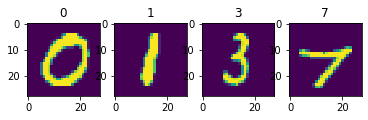

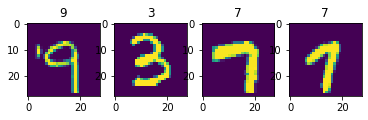

In [35]:
# 将数据打乱后再输出
mnist_dataset = tfds.load("mnist", split=tfds.Split.TRAIN, as_supervised=True)
mnist_dataset = mnist_dataset.shuffle(buffer_size=10000).batch(4)
count = 0
for images, lables in mnist_dataset:
    fig, axs = plt.subplots(1,4)
    count += 1
    for i in range(4):
        axs[i].set_title(lables.numpy()[i])
        axs[i].imshow(images.numpy()[i, :, :, 0])
    plt.show()
    if count == 2:
        break
    


tf.data.Dataset作为一个针对大规模数据设计的迭代器，本身无法方便的获取自身元素的数量或随机获取访问元素。 
为了高效且充分的打散数据集，需要一些特定的方案。  
Dataset.shuffle采用了以下方法：  
- 设定一个固定大小的buffer_size的缓冲区
- 初始化时，取出数据集中的前buffer_size个元素放入缓冲区
- 每次需要从数据集中取元素时，即从缓冲区中随机采样一个元素并取出，然后从后续元素中取出一个放回到被取出的位置，以维持缓冲区大小  

** 因此，缓冲区大小需要依据数据集特性和数据排列特点来进行设置 **
- 当 buffer_size = 1 时， 相当于没有打散  
- 当数据标签分布极不均匀时，较小的缓冲区大小会使训练时取出的batch数据很可能全部为同一便签，从而影响训练效果。  
- 一般而言，数据集的分布若较为均匀，则缓冲区大小可较小，否则需要设置较大缓冲区 

### 使用tf.data的并行化策略来提高训练流程效率
有时训练过程中， 数据集的准备有时非常耗时，这时就会由cpu忙碌但是gpu空载的情况，造成数据的浪费。 

<img src="https://tf.wiki/_images/datasets_without_pipelining_zh.png">

tf.data提供了Dataset.prefetch() 方法，使得可以让数据集对象Dataset在训练时预取出若干个元素。使得GPU训练的同时，CPU可以准备数据

<img src="https://tf.wiki/_images/datasets_with_pipelining_zh.png">

使用方法和shuffle(). batch() 类似
```python
mnist_dataset = mnist_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) 
``` 
buffer_size可以手动设置，也可以设置为AUTOTUNE由tensorflow自动选择合适的数值

同样的，Dataset.map()也可以利用多GPU资源，并行化的对数据项进行变换，从而提高效率。  
假设用于训练的计算机有2核的CPU，我们希望充分利用利用多核心的优势对数据进行并行化变化，可以使用：   
```python
    mnist_dataset = mnist_dataset.map(map_func=rot90, num_parallel_calls=2)
```
如下图： 

<img src="https://tf.wiki/_images/datasets_parallel_map_zh.png">

这里的num_parallel_calls也可以设置为 tf.data.experimental.AUTOTUNE 让 tensorflow 进行自行选择

### 数据集元素的获取与使用
td.data.Dataset是一个python的可迭代对象，可以直接在for循环中使用  
```python
    dataset = tf.data.Dataset.from_tensor_slices((A,B,C,..))
````
当然也可以使用iter()显性的构造一个迭代器  

keras 支持使用tf.data.Dataset 直接作为输入，当调用 tf.keras.Model的fit和evaluate()方法时  
可以将参数中的输入数据x指定为一个元素格式为(输入数据， 标签数据)的 Dataset, 并且忽略掉参数中的标签数据y